In [47]:
import pandas as pd
import seaborn as se
import pickle
from collections import Counter
import numpy as np
import os
import pickle
from timeit import timeit
import json
from timeit import default_timer as timer
from pathlib import Path
import shutil
import math
import matplotlib.pyplot as plt
from math import sqrt
from tqdm import tqdm
import matplotlib.ticker as mtick

In [48]:
se.set_style("darkgrid")

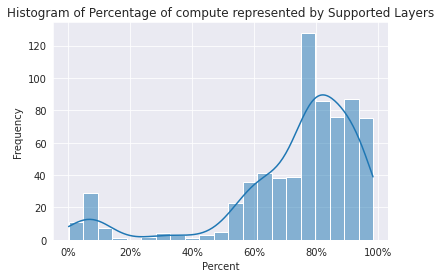

In [49]:
arch_metrics = pd.read_csv('../data/arch_metrics_iofmap_1mb.csv', index_col=[0,1],)

plt = se.histplot(x = arch_metrics["percent_of_compute"].groupby(level=0).sum().multiply(100), kde=True)
plt.set_title('Histogram of Percentage of compute represented by Supported Layers')
plt.set_xlabel('Percent')
plt.set_ylabel('Frequency')
plt.xaxis.set_major_formatter(mtick.PercentFormatter())
# present as CDF and Histogram

Text(0.5, 1.0, 'Accelerator Speedup Factor Over CPU Baseline')

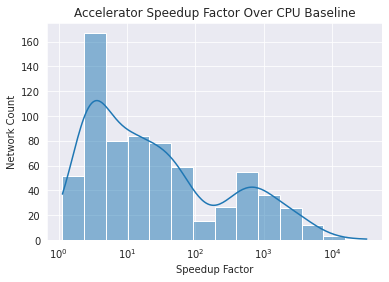

In [50]:
arch_metrics = pd.read_csv('../data/arch_metrics_iofmap_1mb.csv', index_col=[0,1],)

plt = se.histplot(x = arch_metrics['speedup'].groupby(level=0).mean(), log_scale=True, kde=True)
plt.set_xscale('log', base=10)
plt.set_xlabel('Speedup Factor')
plt.set_ylabel('Network Count')
plt.set_title('Accelerator Speedup Factor Over CPU Baseline')

Text(0.5, 1.0, 'Inferences/J')

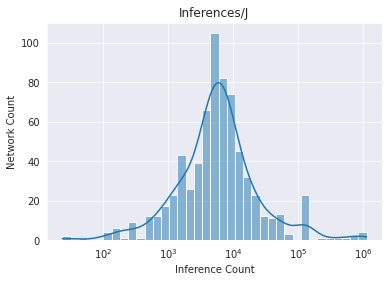

In [51]:
arch_metrics = pd.read_csv('../data/arch_metrics_iofmap_1mb.csv', index_col=[0,1],)

inferences_per_joule = arch_metrics.groupby(level = 0).mean().loc[:, ~arch_metrics.columns.isin(['latency', 'load_bw', 'store_bw', 'speedup', 'percent_of_compute', 'util'])].sum(axis = 1).pow(-1)
plt = se.histplot(inferences_per_joule, log_scale=True, kde=True)
plt.set_xscale('log', base=10)
plt.set_xlabel('Inference Count')
plt.set_ylabel('Network Count')
plt.set_title('Inferences/J')


In [52]:
arch_metrics = pd.read_csv('../data/arch_metrics_iofmap_1mb.csv', index_col=[0,1],)

energy_per_inference = arch_metrics.groupby(level = 0).mean().loc[:, ~arch_metrics.columns.isin(['latency', 'load_bw', 'store_bw', 'speedup', 'percent_of_compute', 'util'])]
energy_per_inference.mean()

dram_energy                5.922364e-04
ifmap_sram_energy          8.934231e-07
psum_sram_energy           2.531178e-07
reuse_chain_sram_energy    2.999377e-08
weight_sram_energy         1.475684e-07
mac_energy                 7.341871e-17
dtype: float64

Text(0.5, 1.0, 'Bandwidth distribution')

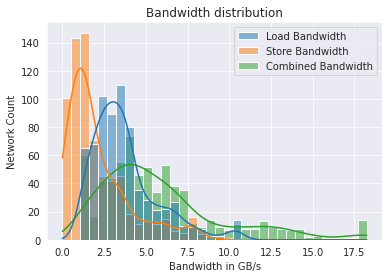

In [53]:
arch_metrics = pd.read_csv('../data/arch_metrics_iofmap_1mb.csv', index_col=[0,1],)

bw_df = arch_metrics.groupby(level = 0).mean().loc[:, arch_metrics.columns.isin(['load_bw', 'store_bw'])].div(2**30)
bw_df["combined"] = bw_df["load_bw"] + bw_df["store_bw"]
bw_df = bw_df.rename(columns={'load_bw': "Load Bandwidth", "store_bw": "Store Bandwidth", "combined":"Combined Bandwidth"})
plt = se.histplot(data = bw_df, kde=True)
plt.set_xlabel('Bandwidth in GB/s')
plt.set_ylabel('Network Count')
plt.set_title('Bandwidth distribution')

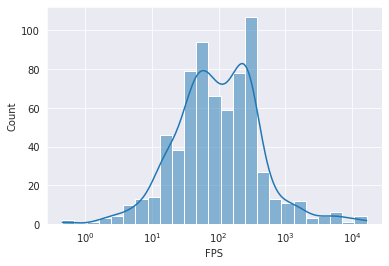

In [54]:
arch_metrics = pd.read_csv('../data/arch_metrics_iofmap_1mb.csv', index_col=[0,1],)

fps = arch_metrics.groupby(level = 0).sum().loc[:, arch_metrics.columns.isin(['latency'])].mul(1*10**-9).pow(-1)
fps = fps.rename(columns={"latency": "FPS"})
plt = se.histplot(data = fps, x = "FPS", kde=True, log_scale=True)

Text(0.5, 1.0, 'Utilization distribution')

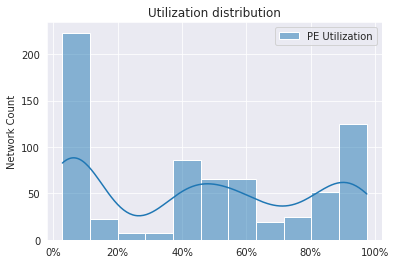

In [55]:
arch_metrics = pd.read_csv('../data/arch_metrics_iofmap_1mb.csv', index_col=[0,1],)

util = arch_metrics.groupby(level = 0).mean().loc[:, arch_metrics.columns.isin(['util'])].mul(100)
util = util.rename(columns={"util": "PE Utilization"})
plt = se.histplot(data = util, kde=True)
plt.xaxis.set_major_formatter(mtick.PercentFormatter())
plt.set_ylabel('Network Count')
plt.set_title('Utilization distribution')

/tmp/ipykernel_3982423/1809436263.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.ax_marg_x.set_xticklabels([r'$10^{'+str(i)+'}$' for i in plt.ax_marg_x.get_xticks()])
/tmp/ipykernel_3982423/1809436263.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.ax_marg_y.set_yticklabels([r'$10^{'+str(i)+'}$' for i in plt.ax_marg_y.get_yticks()])


Text(0.5, -0.2, 'Contour Plot of PE Utilization vs MAC Operations')

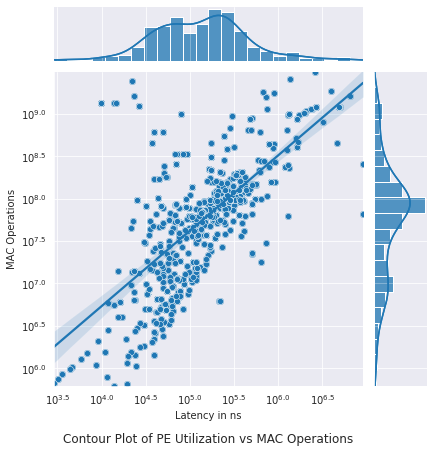

In [56]:
arch_metrics = pd.read_csv('../data/arch_metrics_iofmap_1mb.csv', index_col=[0,1],)
layer_metrics = pd.read_csv('../data/layer_metrics.csv', index_col=[0,1],)

latency = pd.DataFrame(np.log10(arch_metrics["latency"].groupby(level=0).mean()).copy())
macs = pd.DataFrame(np.log10(layer_metrics["macs"].groupby(level=0).mean()).copy())
latency_vs_mac_df = latency.join(macs)

plt = se.jointplot(
    data=latency_vs_mac_df,
    x="latency",
    y="macs",
    kind="reg",
    # cmap="Blues",
    # zorder=2,
    # levels=10,
    # alpha=0.9,
    # shade=True,
    # thresh=0,
    ylim=(
        latency_vs_mac_df[["macs"]].min().item(),
        latency_vs_mac_df[["macs"]].max().item(),
    ),
    xlim=(
        latency_vs_mac_df[["latency"]].min().item(),
        latency_vs_mac_df[["latency"]].max().item(),
    ),
)
plt.plot_joint(se.scatterplot)
plt.plot_marginals(se.histplot, zorder=0, kde=True)
plt.ax_marg_x.set_xticklabels([r'$10^{'+str(i)+'}$' for i in plt.ax_marg_x.get_xticks()])
plt.ax_marg_y.set_yticklabels([r'$10^{'+str(i)+'}$' for i in plt.ax_marg_y.get_yticks()])
plt.ax_joint.set_ylabel('MAC Operations')
plt.ax_joint.set_xlabel('Latency in ns')
plt.ax_joint.set_title('Contour Plot of PE Utilization vs MAC Operations', y = -0.2)


/tmp/ipykernel_3982423/1860206424.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.ax_marg_x.set_xticklabels([r'$10^{'+str(i)+'}$' for i in plt.ax_marg_x.get_xticks()])
/tmp/ipykernel_3982423/1860206424.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.ax_marg_x.set_xticklabels([r'$10^{'+str(i)+'}$' for i in plt.ax_marg_x.get_xticks()])


Text(0.5, -0.2, 'Contour Plot of Avg. Network PE Utilization & Avg. Network Latency')

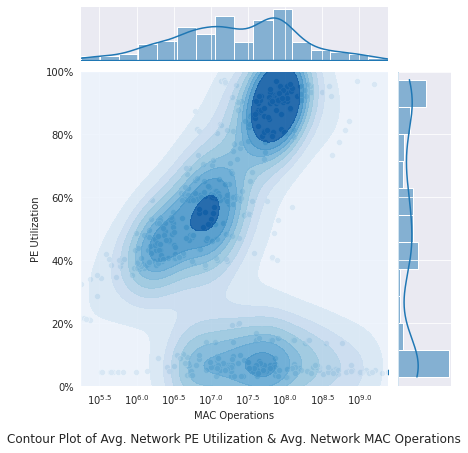

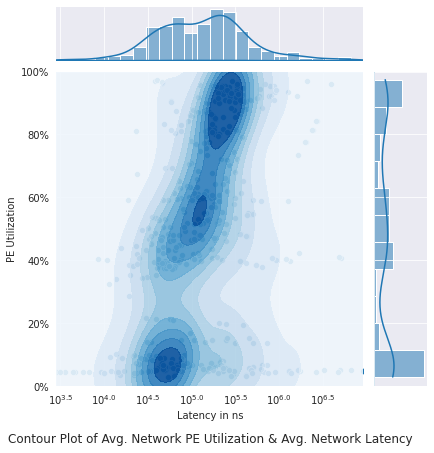

In [57]:
layer_metrics = pd.read_csv('../data/layer_metrics.csv', index_col=[0, 1])
arch_metrics = pd.read_csv('../data/arch_metrics_iofmap_1mb.csv', index_col=[0,1],)

util = arch_metrics.groupby(level = 0).mean().loc[:, arch_metrics.columns.isin(['util'])].mul(100)
layer_metrics['macs'] = np.log10(layer_metrics['macs'])
macs_vs_util_df = pd.DataFrame(layer_metrics['macs'].groupby(level=0).mean()).join(util)
# plt = se.jointplot(data = macs_vs_util_df, x='macs', y='util', kind="hex", ylim=(0, 100))
# plt.plot_joint(se.kdeplot, color="#47C2F9", zorder=1, levels=5)

plt = se.jointplot(
    data=macs_vs_util_df,
    x="macs",
    y="util",
    kind="kde",
    cmap="Blues",
    zorder=5,
    levels=10,
    alpha=0.9,
    shade=True,
    thresh=0,
    ylim=(0, 100),
    xlim=(
        macs_vs_util_df[["macs"]].min().item(),
        macs_vs_util_df[["macs"]].max().item(),
    ),
)
plt.plot_joint(se.scatterplot)
plt.plot_marginals(se.histplot, zorder=0, kde=True)
plt.ax_marg_y.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ax_marg_x.set_xticklabels([r'$10^{'+str(i)+'}$' for i in plt.ax_marg_x.get_xticks()])
plt.ax_joint.set_ylabel('PE Utilization')
plt.ax_joint.set_xlabel('MAC Operations')
plt.ax_joint.set_title('Contour Plot of Avg. Network PE Utilization & Avg. Network MAC Operations', y = -0.2)



latency = arch_metrics[['latency']].groupby(level=0).mean()
latency = np.log10(latency)
latency_vs_util = latency.join(arch_metrics[['util']].groupby(level=0).mean().mul(100))

plt = se.jointplot(
    data=latency_vs_util,
    x="latency",
    y="util",
    kind="kde",
    cmap="Blues",
    zorder=5,
    levels=10,
    alpha=0.9,
    shade=True,
    thresh=0,
    ylim=(0, 100),
    xlim=(
        latency_vs_util[["latency"]].min().item(),
        latency_vs_util[["latency"]].max().item(),
    ),
)
plt.plot_joint(se.scatterplot)
plt.plot_marginals(se.histplot, zorder=0, kde=True)
plt.ax_marg_y.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ax_marg_x.set_xticklabels([r'$10^{'+str(i)+'}$' for i in plt.ax_marg_x.get_xticks()])
plt.ax_joint.set_ylabel('PE Utilization')
plt.ax_joint.set_xlabel('Latency in ns')
plt.ax_joint.set_title('Contour Plot of Avg. Network PE Utilization & Avg. Network Latency', y = -0.2)


/tmp/ipykernel_3982423/3789608731.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.ax_marg_x.set_xticklabels([r'$2^{'+str(i)+'}$' for i in plt.ax_marg_x.get_xticks()])
/tmp/ipykernel_3982423/3789608731.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.ax_marg_x.set_xticklabels([r'$2^{'+str(i)+'}$' for i in plt.ax_marg_x.get_xticks()])


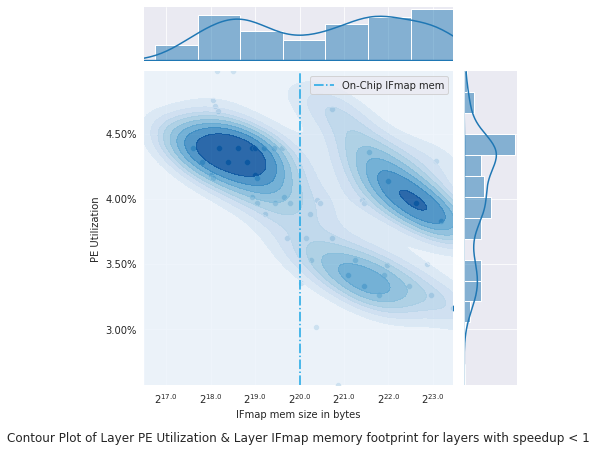

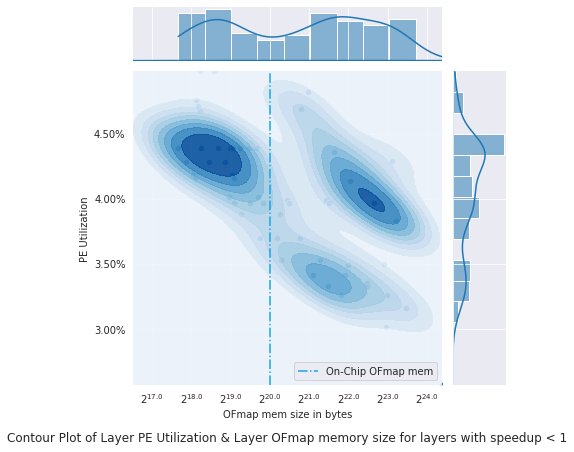

In [58]:
arch_metrics = pd.read_csv('../data/arch_metrics_iofmap_1mb.csv', index_col=[0,1],)
layer_properties = pd.read_csv('../data/layer_metrics.csv', index_col=[0, 1])

util = arch_metrics['util']
speedup = arch_metrics['speedup']
slow_layers_with_low_util = arch_metrics[['util', 'speedup']]
slow_layers_with_low_util = slow_layers_with_low_util[(util < 0.05) & (speedup < 1)]
slow_layer_properties = layer_properties[layer_properties.index.isin(slow_layers_with_low_util.index)].copy()
slow_layer_properties.loc[:, 'total_mem_size'] = pd.DataFrame(np.log2(slow_layer_properties['ifmap_mem_size'] + slow_layer_properties['ofmap_mem_size']))
slow_layer_properties.loc[:, 'ifmap_mem'] = pd.DataFrame(np.log2(slow_layer_properties['ifmap_mem_size']))
slow_layer_properties.loc[:, 'ofmap_mem'] = pd.DataFrame(np.log2(slow_layer_properties['ofmap_mem_size']))
slow_layer_properties.loc[:, 'util'] = slow_layers_with_low_util['util'].mul(100)
plt = se.jointplot(
    data=slow_layer_properties,
    x="ifmap_mem",
    y="util",
    kind="kde",
    cmap="Blues",
    zorder=5,
    levels=10,
    alpha=0.85,
    shade=True,
    thresh=0,
    ylim=(
        slow_layer_properties[["util"]].min().item(),
        slow_layer_properties[["util"]].max().item(),
    ),
    xlim=(
        16.5,
        slow_layer_properties[["ifmap_mem"]].max().item(),
    ),
)
plt.plot_joint(se.scatterplot)
plt.plot_marginals(se.histplot, zorder=1, kde=True)
plt.ax_marg_y.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ax_marg_x.set_xticklabels([r'$2^{'+str(i)+'}$' for i in plt.ax_marg_x.get_xticks()])
plt.ax_joint.set_ylabel('PE Utilization')
plt.ax_joint.set_xlabel('IFmap mem size in bytes')
plt.ax_joint.set_title('Contour Plot of Layer PE Utilization & Layer IFmap memory footprint for layers with speedup < 1', y = -0.2)
plt.ax_joint.axvline(x = 20, color='#18A5E5', alpha=1, linestyle='-.', zorder=10, label='On-Chip IFmap mem')
plt.ax_joint.legend()

plt = se.jointplot(
    data=slow_layer_properties,
    x="ofmap_mem",
    y="util",
    kind="kde",
    cmap="Blues",
    zorder=5,
    levels=10,
    alpha=0.9,
    shade=True,
    thresh=0,
    ylim=(
        slow_layer_properties[["util"]].min().item(),
        slow_layer_properties[["util"]].max().item(),
    ),
    xlim=(
        16.5,
        slow_layer_properties[["ofmap_mem"]].max().item(),
    ),
)
plt.plot_joint(se.scatterplot)
plt.plot_marginals(se.histplot, zorder=0, kde=True)
plt.ax_marg_y.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ax_marg_x.set_xticklabels([r'$2^{'+str(i)+'}$' for i in plt.ax_marg_x.get_xticks()])
plt.ax_joint.set_ylabel('PE Utilization')
plt.ax_joint.set_xlabel('OFmap mem size in bytes')
plt.ax_joint.set_title('Contour Plot of Layer PE Utilization & Layer OFmap memory size for layers with speedup < 1', y = -0.2)
plt.ax_joint.axvline(x = 20, color='#18A5E5', alpha=1, linestyle='-.', zorder=10, label='On-Chip OFmap mem')
plt.ax_joint.legend()


Text(0.5, -0.3, 'Types of layers with low utilizationl, speedup < 1 and small memory footprint')

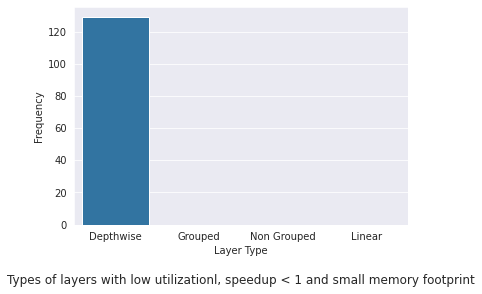

In [59]:
layer_metrics = pd.read_csv('../data/layer_metrics.csv', index_col=[0, 1])
arch_metrics = pd.read_csv('../data/arch_metrics_iofmap_1mb.csv', index_col=[0,1],)
aggregate_metrics = arch_metrics.join(layer_metrics)
layers = aggregate_metrics[['util', 'ifmap_mem_size', 'speedup', 'ofmap_mem_size']]
layers = layers[(layers['ifmap_mem_size'] < 2**20)]
layers = layers[(layers['ofmap_mem_size'] < 2**20)]
layers = layers[(layers['speedup'] < 1)]
layers = layers[(layers['util'] < 0.05)]

layers = aggregate_metrics[arch_metrics.index.isin(layers.index)]
depthwise_layers = len(layers[layers['groups'] == layers['channels']])
grouped_conv_layers = len(layers[(layers['groups'] != layers['channels']) & (layers['groups'] > 1)])
conv_layers = len(layers[(layers['groups'] == 1)])
non_conv_layers = len(layers[layers['type'] != 'conv'])

counts = pd.DataFrame({
    'Layer Type': ['Depthwise', 'Grouped', 'Non Grouped', 'Linear'],
    'Frequency': [depthwise_layers, grouped_conv_layers, conv_layers, non_conv_layers],
})
plt = se.barplot(data = counts, x='Layer Type', y = 'Frequency')
plt.set_title("Types of layers with low utilizationl, speedup < 1 and small memory footprint", y = -0.3)

In [60]:
from generate_layer_properties import ConvLayer, LinearLayer
import pickle
with open("../data/model_unique_layers_tracker.pickle", "rb") as file:
    model_unique_layers_tracker = pickle.load(file)

Text(0.5, 1.0, 'Per Layer Speedup vs CPU Baseline for mobilenetv3_small_075')

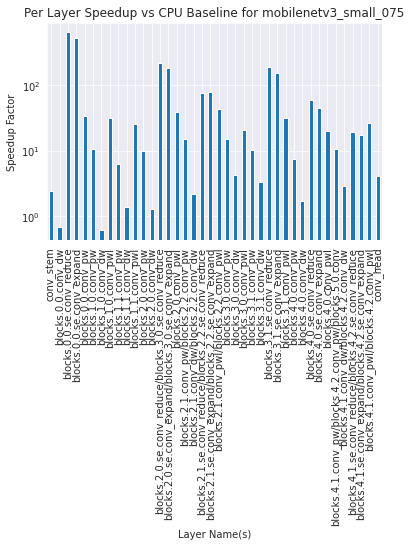

In [61]:
layer_metrics = pd.read_csv('../data/layer_metrics.csv', index_col=[0, 1])
arch_metrics = pd.read_csv('../data/arch_metrics_iofmap_1mb.csv', index_col=[0,1],)

model_name = "mobilenetv3_small_075"
combined_model_metrics = {}
for group_idx, layer_names in model_unique_layers_tracker[model_name].items():
    group_metrics = arch_metrics.loc[([model_name],layer_names), : ].mean()
    combined_layer_names = '/'.join(layer_names)
    combined_model_metrics[combined_layer_names] = group_metrics.to_dict()
combined_model_df = pd.DataFrame.from_dict(combined_model_metrics, orient='index')
speedup_plt = combined_model_df.loc[:, 'speedup'].plot(kind='bar')
speedup_plt.set_yscale('log', base=10)
speedup_plt.set_ylabel('Speedup Factor')
speedup_plt.set_xlabel('Layer Name(s)')
speedup_plt.set_title(f"Per Layer Speedup vs CPU Baseline for {model_name}")



Text(0, 0.5, 'Utilization percentage')

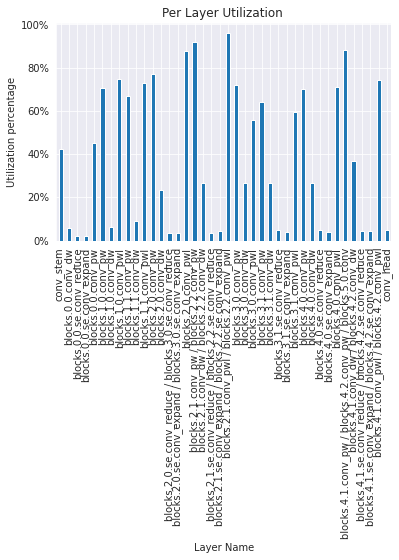

In [62]:
combined_model_metrics = {}
for group_idx, layer_names in model_unique_layers_tracker[model_name].items():
    group_metrics = arch_metrics.loc[([model_name],layer_names), : ].mean()
    combined_layer_names = ' / '.join(layer_names)
    combined_model_metrics[combined_layer_names] = group_metrics.to_dict()
combined_model_df = pd.DataFrame.from_dict(combined_model_metrics, orient='index')

util_plt = combined_model_df.loc[:, 'util'].mul(100).plot(kind='bar')
util_plt.set_title("Per Layer Utilization ")
util_plt.yaxis.set_major_formatter(mtick.PercentFormatter())
util_plt.set_xlabel('Layer Name')
util_plt.set_ylabel('Utilization percentage')

Text(0, 0.5, 'Energy in Joules')

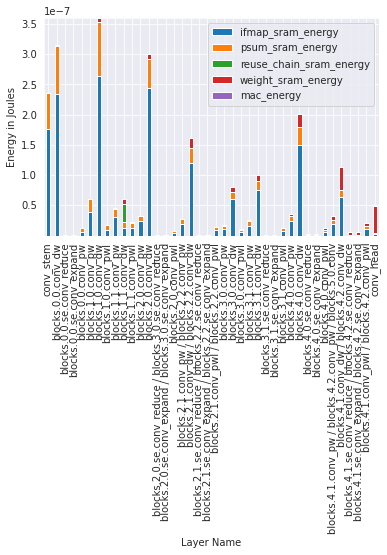

In [63]:

energy_plt = combined_model_df.loc[:, ["ifmap_sram_energy", "psum_sram_energy", "reuse_chain_sram_energy", "weight_sram_energy", "mac_energy"]].plot(kind='bar', stacked=True)
energy_plt.set_xlabel('Layer Name')
energy_plt.set_ylabel('Energy in Joules')